predict the pos_mask given the:
- vocab
- hidden output
of beit using a MLP head.

if one succeeds: we can use it as the core of actor.
if none succeeds: we need another way.

In [ ]:
from env import LimitedHistory
import torch
import torch.utils.data as D
from dataset import COCODataset
from matplotlib import pyplot as plt
import einops
import time
import IPython
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from transformers import BeitForMaskedImageModeling
from lightning.pytorch.loggers import WandbLogger


In [ ]:
class CustomLimitedHistory(LimitedHistory):
    def __init__(self, max_len, width, height, patch_size):
        self.max_len = max_len
        self.patch_size = patch_size
        self.loc_to_patch = {}
        self.loc_history = []
        self.image = None

        self.canvas = torch.zeros((3, height, width),
                                  dtype=torch.float32)
        self.kmask = torch.ones(
            height, width, dtype=torch.bool)
        self.max_row = height // patch_size[0]
        self.max_col = width // patch_size[1]
        
    def set_image(self, image):
        self.loc_history = []
        self.loc_to_patch = {}
        self.image = image
        
    def _set_patch(self, p, on, row, col):
        top = self.patch_size[0] * row
        bottom = top + self.patch_size[0]
        left = self.patch_size[1] * col
        right = left + self.patch_size[1]
        on[..., top:bottom, left:right] = p

    def append(self, row, col):
        patch = self.image[:, row * self.patch_size[0]:(row + 1) * self.patch_size[0],
                           col * self.patch_size[1]:(col + 1) * self.patch_size[1]]
        self.loc_history.append((row, col))
        self.loc_to_patch[(row, col)] = patch
        
    def mask_randomly(self, count=None, percent=None):
        assert count is not None or percent is not None, 'count or percent must be specified'
        assert count is None or percent is None, 'only one of count or percent must be specified'
        if percent is not None:
            count = int(percent * self.max_row * self.max_col)
        for _ in range(count):
            random_loc = (torch.randint(0, self.max_row, (1,)).item(),
                            torch.randint(0, self.max_col, (1,)).item())
            self.append(*random_loc)
            

    def _fill_canvas(self):
        self.kmask.fill_(0)
        self.canvas.fill_(0)
        for loc in self.loc_history:
            self._set_patch(self.loc_to_patch[loc], self.canvas, *loc)
            self._set_patch(1, self.kmask, *loc)
            
    def get_history_dict(self):
        self._fill_canvas()
        return {
            'history': self.canvas,
            'kmask': self.kmask,
        }

In [ ]:
from functools import cache


class MaskerDataset(COCODataset):
    def __init__(self, percent, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.percent = percent
        self.history = CustomLimitedHistory(None, 224, 224, (32, 32))

    @cache
    def __getitem__(self, idx):
        image, _, _ = super().__getitem__(idx)
        self.history.set_image(image)
        self.history.mask_randomly(percent=self.percent)
        return self.history.get_history_dict()

In [ ]:

class MaskPredictor(pl.LightningModule):
    def __init__(self, lr=3e-4):
        super().__init__()
        self.model = BeitForMaskedImageModeling.from_pretrained('microsoft/beit-base-patch16-224-pt22k', 
                                                   proxies={'http': '127.0.0.1:10809', 'https': '127.0.0.1:10809'},)
        # for param in self.model.parameters():
        #     param.requires_grad = False
        self.linear = nn.Linear(self.model.config.vocab_size, 1)
        self.lr = lr
        self.loss = nn.BCEWithLogitsLoss()
        
    def on_before_batch_transfer(self, batch, dataloader_idx):
        batch['kmask'] = batch['kmask'][:, ::self.model.config.patch_size, ::self.model.config.patch_size].flatten(1)
        return batch
        
    def forward(self, batch, *args, **kwargs):
        img, mask = batch['history'], batch['kmask']
        out = self.model(pixel_values=img, bool_masked_pos=mask)
        mask = self.linear(out.logits).squeeze(-1)
        return mask
    
    def training_step(self, batch, batch_idx):
        canvas, mask = batch['history'], batch['kmask']
        mask_hat = self(batch)
        loss = self.loss(mask_hat, mask.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        canvas, mask = batch['history'], batch['kmask']
        mask_hat = self(batch)
        loss = self.loss(mask_hat, mask.to(torch.float32))
        self.log('val_loss', loss)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
dataset = MaskerDataset(.7, train=True, length=100000, no_seg=True, fix_resize=(224, 224))
seed = torch.Generator().manual_seed(42)
train_set_size = int(len(dataset) * .8)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = D.random_split(dataset, [train_set_size, valid_set_size], generator=seed)
train_loader = DataLoader(train_set, batch_size=16, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=16, num_workers=4)

In [ ]:
model = MaskPredictor()
wandb_logger = WandbLogger(project='AttentionRL', mode='disabled')
trainer = pl.Trainer(devices=1, max_epochs=10, logger=wandb_logger)
trainer.fit(model, train_loader, valid_loader)

## Analysis

In [8]:
loaded_model = MaskPredictor.load_from_checkpoint('AttentionRL/5u9gn3tb/checkpoints/epoch=9-step=790.ckpt', map_location='cuda')

In [9]:
valid_split = D.Subset(valid_set, range(2, 3))
predict_loader = DataLoader(valid_split, batch_size=1)

In [10]:
trainer = pl.Trainer()
predictions = trainer.predict(loaded_model, predict_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/server/miniconda3/envs/rl/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

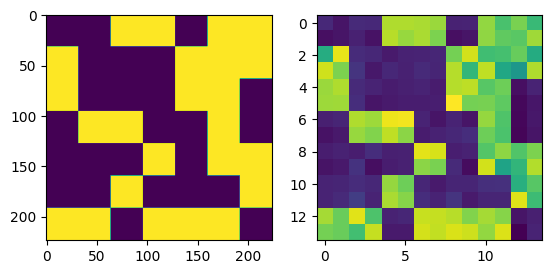

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(valid_split[0]['kmask'])
plt.subplot(1, 2, 2)
plt.imshow(predictions[0].squeeze().view(14, 14))

In [ ]:
# for i in range(100):
#     dict = dataset[i]
#     canvas = dict['history'].to(torch.float32)
#     kmask = dict['kmask']
#     IPython.display.clear_output(wait=True)
#     plt.imshow(einops.rearrange(canvas, 'c h w -> h w c'))
#     IPython.display.display(plt.gcf())
#     plt.imshow(kmask)
#     IPython.display.display(plt.gcf())
#     time.sleep(1)